In [11]:
import datetime as dt
import json
from collections import defaultdict
from enum import Enum
from statistics import mean

import dateutil.parser
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np


def load(path: str):
    fh = open(path)
    data = json.load(fh)
    fh.close()
    return data


data = load("../data/merged-log-SOFTENG206-2022.json")

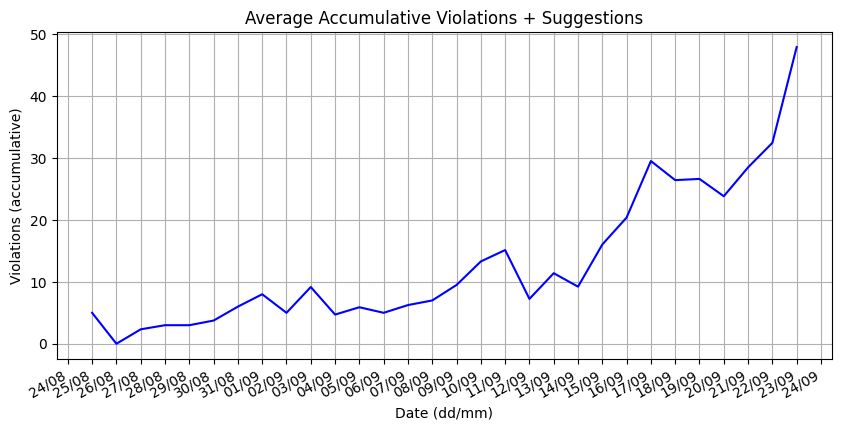

In [42]:
fig, ax1 = plt.subplots(1, 1)

ax1.set_title("Average Accumulative Violations + Suggestions")
ax1.set_xlabel("Date (dd/mm)")
ax1.set_ylabel("Violations (accumulative)")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
ax1.xaxis.set_major_locator(mdates.DayLocator())
fig.autofmt_xdate()
ax1.grid(True)

fig.set_figwidth(7)
fig.set_figwidth(10)


def date_range(start, end):
    delta = end - start
    days = [start + dt.timedelta(days=i) for i in range(delta.days + 1)]
    return days


# sliding window of average vioaltions accumulated between (day to day)
def acc2(data):
    # name => [(date, violations)]
    groups = defaultdict(list)
    for x in data:
        date = dateutil.parser.isoparse(x["date"])
        # time field only became available later but is more accurate
        if "Time" in x:
            date = dateutil.parser.isoparse(x["Time"])

        violations = x["violations"]
        # remove binary biolation as it was very broken at a point
        violations = list(
            filter(
                lambda x: x["Name"] not in ["BinaryViolation", "EmptyCommitViolation"],
                violations,
            )
        )
        groupName = x["name"]
        groups[groupName].append((date, violations))

    # sort each of the data points by date
    for k in groups.keys():
        groups[k] = list(sorted(groups[k], key=lambda x: x[0]))

    # find min and max date
    dates = []
    for (k, ds) in groups.items():
        for (d, v) in ds:
            dates.append(d)

    maxDate = max(d for d in dates if isinstance(d, dt.date))
    minDate = min(d for d in dates if isinstance(d, dt.date))

    # round to nearest day start
    minDate = minDate.replace(hour=0, minute=0, second=0, microsecond=0)
    maxDate = maxDate.replace(hour=0, minute=0, second=0, microsecond=0)

    # range of dates monotomically increasing by day value
    dr = date_range(minDate, maxDate)

    xs = []
    ys = []
    for i in range(0, len(dr) - 2):
        lower = dr[i]
        upper = dr[i + 1]

        vs = []
        # find all dates between update and lower range
        for (gn, ds) in groups.items():
            for (k, varr) in ds:
                if lower <= k <= upper:
                    vs.append(len(varr))

        # can't mean empty arrays, hardcode days with no contribs to [0] (zero mean)
        vs = vs if vs != [] else [0]
        ys.append(mean(vs))
        xs.append(lower)

    plt.plot(xs, ys, c="blue")


# accumulative violations (all violations per workflow run)
def accumulative(data):
    ds = defaultdict(list)  # date
    vs = defaultdict(list)  # violations

    for x in data:
        date = dateutil.parser.isoparse(x["date"])
        # time field only became available later but is more accurate
        if "Time" in x:
            ds[x["name"]].append(x["Time"])
        else:
            ds[x["name"]].append(date)

        # filter binary violations because they were briefly broken and would dirty results
        fs = x["violations"]
        fs = list(
            filter(
                lambda x: x["Name"] not in ["BinaryViolation", "EmptyCommitViolation"],
                fs,
            )
        )
        vs[x["name"]].append(len(fs))

    for k in ds.keys():
        plt.plot(ds[k], vs[k], label=k)

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))


def average(data):
    avgds = []
    avgvs = []
    accds = []
    accvs = []

    for x in data:
        date = dateutil.parser.isoparse(x["date"])
        # time field only became available later but is more accurate
        if "Time" in x:
            avgds.append(x["Time"])
        else:
            avgds.append(date)

        # filter binary violations because they were briefly broken and would dirty results
        vs = x["violations"]
        avgds.copy()
        vs = list(filter(lambda x: x["Name"] not in ["BinaryViolation"], vs))
        accvs.append(len(vs))

    plt.plot(accds, accvs, c="blue")

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))


acc2(data)
# accumulative(data)
# average(data)

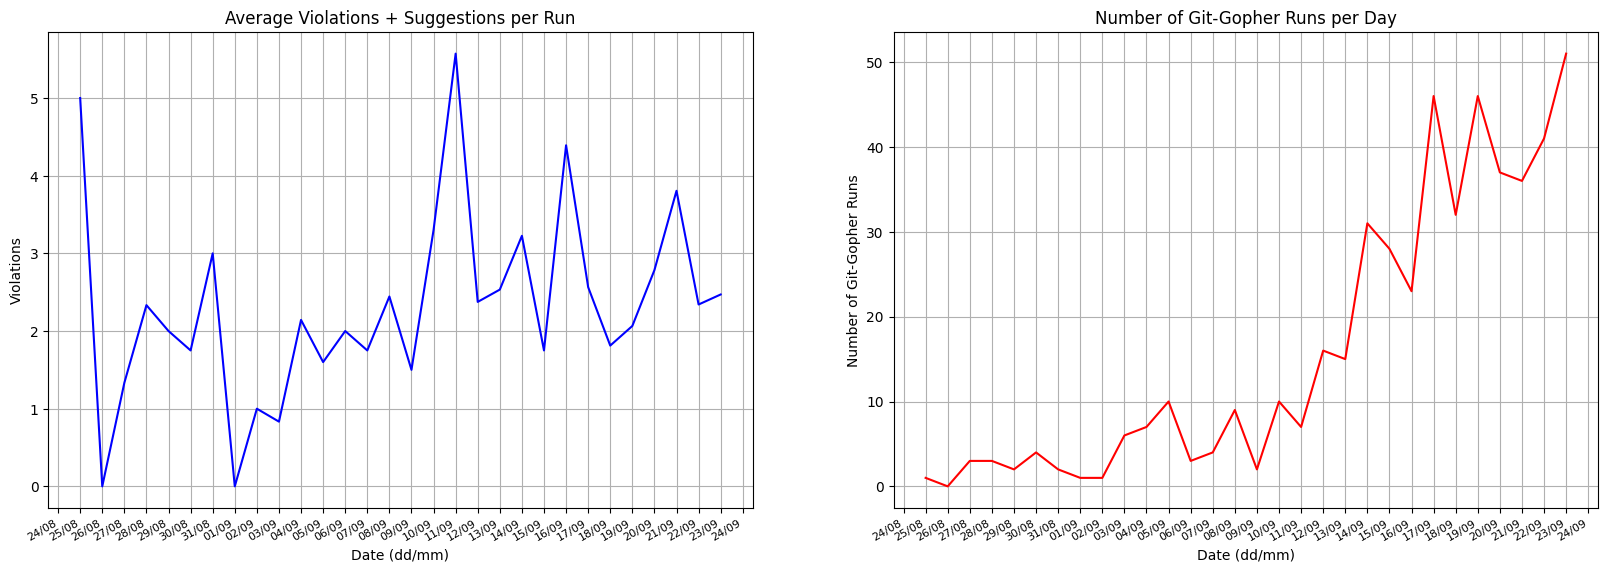

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2)


ax1.set_title("Average Violations + Suggestions per Run")
ax1.set_xlabel("Date (dd/mm)")
ax1.set_ylabel("Violations")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.grid(True)
ax1.tick_params(axis="x", labelsize=8)

ax2.set_title("Number of Git-Gopher Runs per Day")
ax2.set_xlabel("Date (dd/mm)")
ax2.set_ylabel("Number of Git-Gopher Runs")
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
ax2.xaxis.set_major_locator(mdates.DayLocator())
ax2.grid(True)
ax2.tick_params(axis="x", labelsize=8)

fig.set_figheight(7)
fig.set_figwidth(20)
fig.autofmt_xdate()

# logs are "accumulative" violations (ie: all violations that exist within the project.
# instead plot as "new" violations per GHA run
# sliding window of average vioaltions per run between (day to day)
def violationsPerRun(data):
    # name => [(date, violations)]
    groups = defaultdict(list)
    for x in data:
        date = dateutil.parser.isoparse(x["date"])
        # time field only became available later but is more accurate
        if "Time" in x:
            date = dateutil.parser.isoparse(x["Time"])

        violations = x["violations"]
        # remove binary biolation as it was very broken at a point
        violations = list(
            filter(
                lambda x: x["Name"] not in ["BinaryViolation", "EmptyCommitViolation"],
                violations,
            )
        )
        groupName = x["name"]
        groups[groupName].append(
            (date, len(violations))
        )  # group => (date, len violations)

    # sort each of the data points by date
    for k in groups.keys():
        groups[k] = list(sorted(groups[k], key=lambda x: x[0]))

    # convert to average instead of accumulated
    for k in groups.keys():
        vs = groups[k]
        prev_raw = vs[0][1]
        for i in range(1, len(vs)):
            save = vs[i][1]
            vs[i] = (vs[i][0], vs[i][1] - prev_raw)
            prev_raw = save

        groups[k] = vs

    # find min and max date
    dates = []
    for (k, ds) in groups.items():
        for (d, v) in ds:
            dates.append(d)

    maxDate = max(d for d in dates if isinstance(d, dt.date))
    minDate = min(d for d in dates if isinstance(d, dt.date))

    # round to nearest day start
    minDate = minDate.replace(hour=0, minute=0, second=0, microsecond=0)
    maxDate = maxDate.replace(hour=0, minute=0, second=0, microsecond=0)

    # range of dates monotomically increasing by day value
    dr = date_range(minDate, maxDate)

    xs = []
    ys = []

    total_contribs = []
    for i in range(0, len(dr) - 2):
        lower = dr[i]
        upper = dr[i + 1]

        vs = []
        # find all dates between update and lower range
        for (gn, ds) in groups.items():
            for k, no in ds:
                if lower <= k <= upper:
                    vs.append(no)

        total_contribs.append(len(vs))
        # can't mean empty arrays, hardcode days with no contribs to [0] (zero mean)
        vs = vs if vs != [] else [0]

        ys.append(mean(vs))
        xs.append(lower)

    ax1.plot(xs, ys, c="blue")
    ax2.plot(xs, total_contribs, c="red")


violationsPerRun(data)

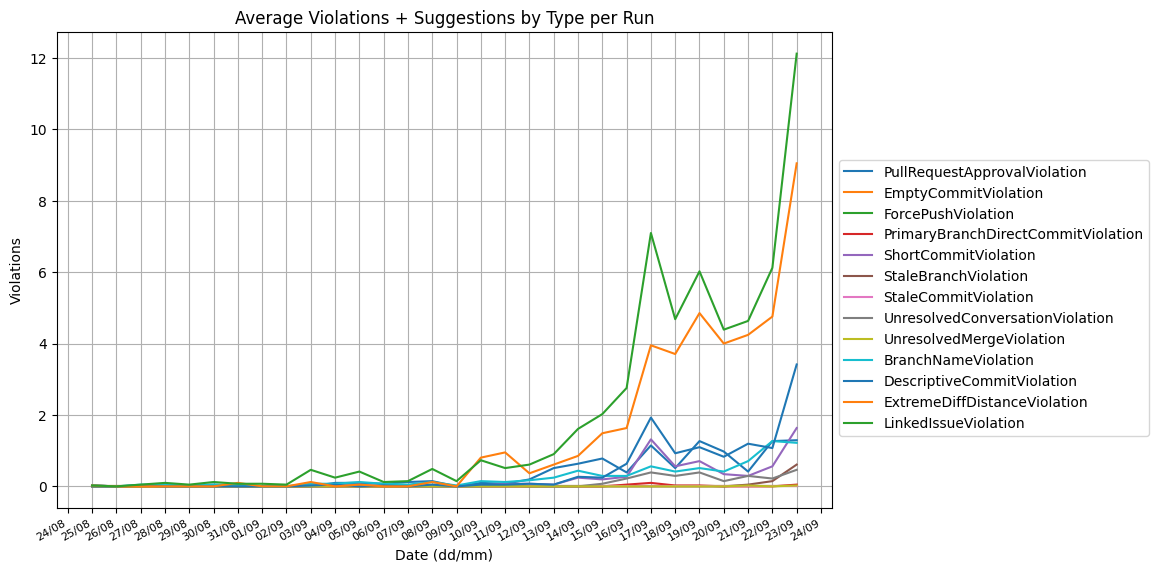

In [52]:
fig, ax1 = plt.subplots(1, 1)


ax1.set_title("Average Violations + Suggestions by Type per Run")
ax1.set_xlabel("Date (dd/mm)")
ax1.set_ylabel("Violations")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.grid(True)
ax1.tick_params(axis="x", labelsize=8)

fig.set_figheight(7)
fig.set_figwidth(10)
fig.autofmt_xdate()

# no binary violation because it's been tainted by a bug (invalid data)
violationNames = [
    "PullRequestApprovalViolation",
    "EmptyCommitViolation",
    "ForcePushViolation",
    "PrimaryBranchDirectCommitViolation",
    "ShortCommitViolation",
    "StaleBranchViolation",
    "StaleCommitViolation",
    "UnresolvedConversationViolation",
    "UnresolvedMergeViolation",
]
suggestionNames = [
    "BranchNameViolation",
    "DescriptiveCommitViolation",
    "ExtremeDiffDistanceViolation",
    "LinkedIssueViolation",
]


# logs are "accumulative" violations (ie: all violations that exist within the project.
# instead plot as "new" violations per GHA run
# sliding window of average vioaltions per run between (day to day)
def byType(data):
    # name => [(date, violations)]
    groups = defaultdict(list)
    for x in data:
        date = dateutil.parser.isoparse(x["date"])
        # time field only became available later but is more accurate
        if "Time" in x:
            date = dateutil.parser.isoparse(x["Time"])

        violations = x["violations"]

        # remove binary biolation as it was very broken at a point
        violations = list(
            filter(
                lambda x: x["Name"] not in ["BinaryViolation", "EmptyCommitViolation"],
                violations,
            )
        )

        violations = list(map(lambda v: v["Name"], violations))
        groupName = x["name"]
        groups[groupName].append((date, violations))  # group => (date, len violations)

    # sort each of the data points by date
    for k in groups.keys():
        groups[k] = list(sorted(groups[k], key=lambda x: x[0]))

    # convert to average instead of accumulated
    for k in groups.keys():
        vs = groups[k]
        prev_raw = vs[0][1]
        for i in range(1, len(vs)):
            save = vs[i][1]
            cpy = vs[i][1]
            for v in prev_raw:
                if v in cpy:
                    cpy.remove(v)
            vs[i] = (vs[i][0], cpy)
            prev_raw = save
        groups[k] = vs

    # find min and max date
    dates = []
    for (k, ds) in groups.items():
        for (d, v) in ds:
            dates.append(d)

    maxDate = max(d for d in dates if isinstance(d, dt.date))
    minDate = min(d for d in dates if isinstance(d, dt.date))

    # round to nearest day start
    minDate = minDate.replace(hour=0, minute=0, second=0, microsecond=0)
    maxDate = maxDate.replace(hour=0, minute=0, second=0, microsecond=0)

    # range of dates monotomically increasing by day value
    dr = date_range(minDate, maxDate)

    # plot each violation frequency per run over time
    for vn in violationNames + suggestionNames:
        xs = []
        ys = []
        for i in range(0, len(dr) - 2):
            lower = dr[i]
            upper = dr[i + 1]

            vs = []
            # find all dates between update and lower range
            for (gn, ds) in groups.items():
                group_total = 0
                for k, vs2 in ds:
                    for v in vs2:
                        if (lower <= k <= upper) and v == vn:
                            group_total += 1
                vs.append(group_total)

            # can't mean empty arrays, hardcode days with no contribs to [0] (zero mean)
            vs = vs if vs != [] else [0]

            ys.append(mean(vs))
            xs.append(lower)

        ax1.plot(xs, ys, label=vn)
    fig.legend(loc="center left", bbox_to_anchor=(0.9, 0.5))


byType(data)